In [1]:
from skimage import measure
from skimage import filters
from numba import njit
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sever.data_loader import PostProcessor

In [2]:
def random_channel_mask():
    n = 5
    l = 512
    im = np.zeros((l, l))
    points = l * np.random.random((2, n ** 2))
    im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    im = filters.gaussian(im, sigma= l / (10. * n))
    blobs = im > 4 * im.mean()
    return blobs

(4, 512, 512)


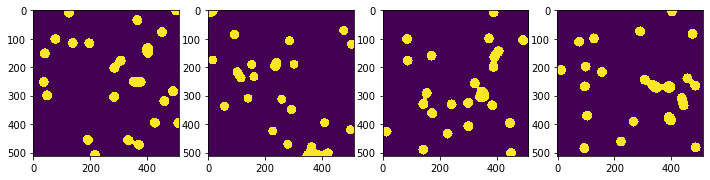

In [7]:
a = random_channel_mask()
b = random_channel_mask()
c = random_channel_mask()
d = random_channel_mask()
p = np.stack([a, b, c, d], axis=0)
print(p.shape)
fig, axs = plt.subplots(1, 4, figsize=(12, 12))
axs[0].imshow(a)
axs[1].imshow(b)
axs[2].imshow(c)
axs[3].imshow(d)

In [8]:
pp = PostProcessor(min_class_sizes=[200, 200, 200, 200])

In [9]:
mask = pp.process(p)
mask.shape

(4, 512, 512)

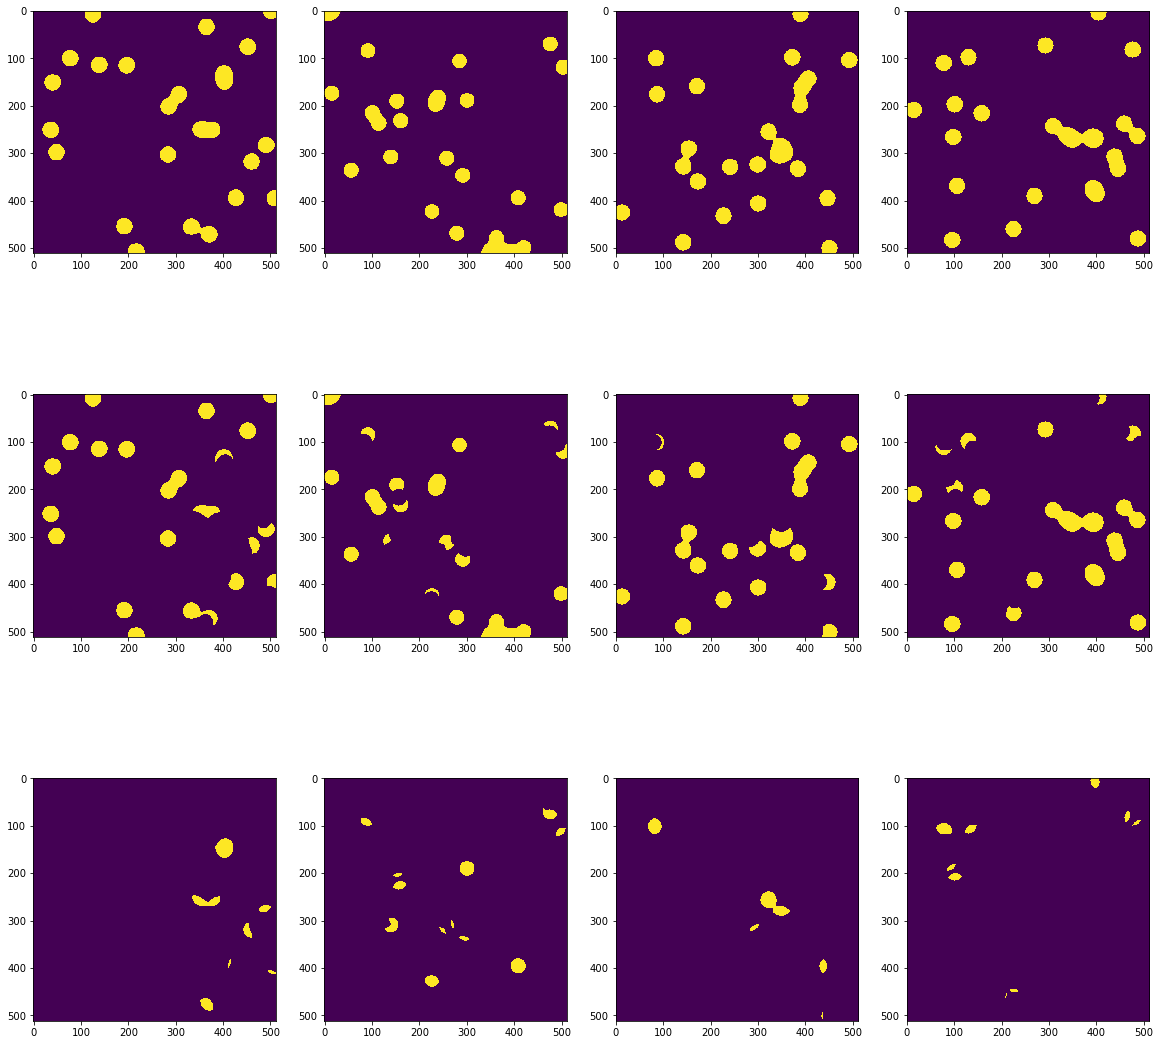

In [10]:
a_ = mask[0, :, :]
b_ = mask[1, :, :]
c_ = mask[2, :, :]
d_ = mask[3, :, :]
fig, axs = plt.subplots(3, 4, figsize=(20, 20))
axs[0, 0].imshow(a)
axs[0, 1].imshow(b)
axs[0, 2].imshow(c)
axs[0, 3].imshow(d)
axs[1, 0].imshow(a_)
axs[1, 1].imshow(b_)
axs[1, 2].imshow(c_)
axs[1, 3].imshow(d_)
axs[2, 0].imshow(a - a_)
axs[2, 1].imshow(b - b_)
axs[2, 2].imshow(c - c_)
axs[2, 3].imshow(d - d_)

In [107]:
def component_domination(p):
    components, component_sizes = _find_components(p)
    m = _write_preds(components, component_sizes)
    return m

def _find_components(p):
    C, H, W = p.shape
    total_components = 0
    channel_components = []
    for c in range(C):
        max_label, labelled_components = cv2.connectedComponents(p[c].astype(np.uint8))
        n_components = max_label - 1
        labelled_components[labelled_components > 0] += total_components  # offset labels
        total_components += n_components
        channel_components.append(labelled_components)
    components = np.stack(channel_components, axis=0)
    component_sizes = [(label, (components == label).sum()) for label in range(1, total_components+1)]
    component_sizes = sorted(component_sizes, key=lambda item: item[1])  # sort by size
    return components, component_sizes

def _write_preds(components, component_sizes):
    C, H, W = components.shape
    m = np.zeros(p.shape, dtype=np.uint8)
    for label, size in component_sizes:
        component_mask_3d = components == label
        component_mask_flatten = component_mask_3d.any(axis=0)
        component_mask_expand = np.repeat(component_mask_flatten[np.newaxis, :, :], C, axis=0)

        # set the mask region to zero across all channels
        m[component_mask_expand] = 0

        # set just the channel applicable to the mask to 1
        m[component_mask_3d] = 1
    return m

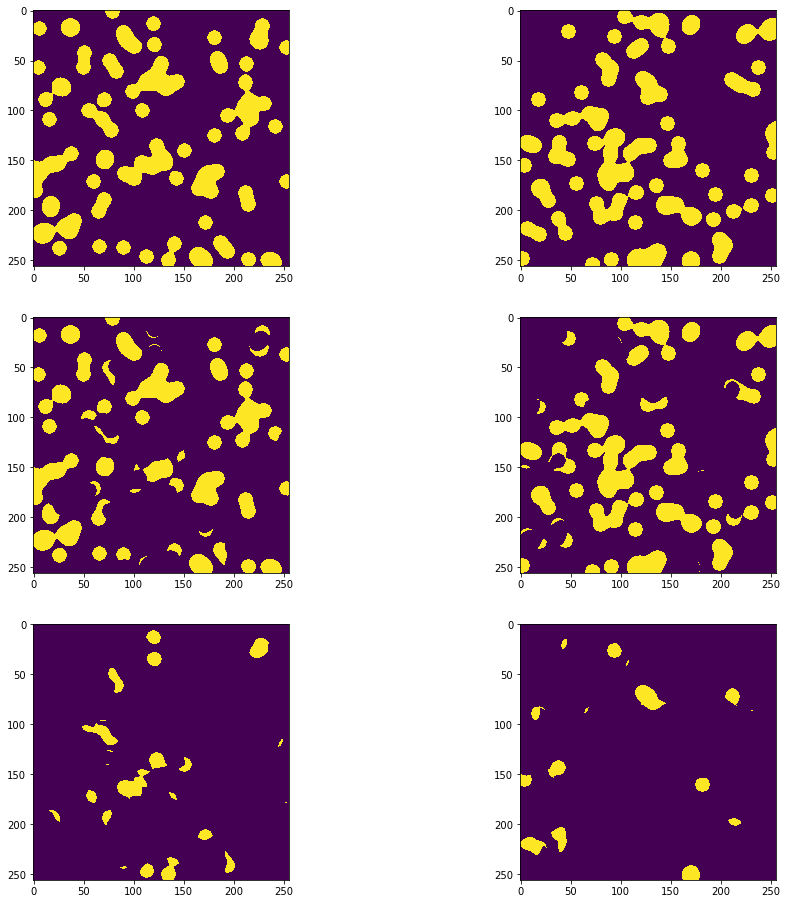

In [108]:
m = component_domination(p)
a_ = m[0, :, :]
b_ = m[1, :, :]
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
axs[0, 0].imshow(a)
axs[0, 1].imshow(b)
axs[1, 0].imshow(a_)
axs[1, 1].imshow(b_)
axs[2, 0].imshow(a - a_)
axs[2, 1].imshow(b - b_)

In [112]:
threshold = np.array([0.3, 0.4])
r = np.random.rand(2, 3, 3)
print(r)
r > threshold[:, np.newaxis, np.newaxis]

[[[0.83678594 0.56912713 0.46975601]
  [0.75783896 0.43517061 0.78789503]
  [0.93466037 0.14855105 0.22307526]]

 [[0.48628859 0.22343163 0.3027209 ]
  [0.54954617 0.34046917 0.62241817]
  [0.14282232 0.63671086 0.16567195]]]


array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True, False, False]],

       [[ True, False, False],
        [ True, False,  True],
        [False,  True, False]]])